<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/A1.02-Atributos_de_localizacao.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- Descrição dos atributos dos indivíduos e das residências](A1.01-Atributos_dos_individuos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Descrição dos atributos de idade e infectividade potencial relativa dos indivíduos ->](A1.03-Atributos_de_idade_e_infectividade.ipynb)

---


# Construção dos atributos de localização

- Os atributos de localização são baseados em uma divisão da região em **blocos** e **subblocos** e uma associação desses subblocos a **bairros**.

## Atributos dos indivíduos

- Para cada **indivíduo**, temos os seguintes atributos de localização:

    - a sua **localização geoespacial**, na forma de **coordenadas**;
    
    - a **residência** à qual pertence;

## Atributos das residências

- Em relação à **residência**, temos os seguintes atributos:

    - a sua **localização**, na forma de **coordenadas espaciais**;
    
    - o **bairro** ao qual pertence;
    
    - o **bloco** ao qual pertence, que corresponde a uma divisão da região em um reticulado de aproximadamente $1\,\texttt{km}^2$ (mais precisamente 30" x 30", em segundos de arco);
    
    - O **subbloco** ao qual pertence, que corresponde a uma subdivisão do reticulado dos blocos de aproximadamente $100 \times 100 \,\texttt{m}^2$ (mais precisamente 3" x 3", em segundos de arco).
    
    - O **número de residentes**.
    
    - A **lista de seus residentes**.
    
- A seguir, descrevemos melhor como esses atributos são construídos.

In [2]:
import datetime

import os, sys

import yaml

import math

import random

import numpy as np
from scipy.interpolate import interp2d

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [4]:
sns.set_style("darkgrid")

In [5]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 09/Jul/2020


## Dados para a construção dos atributos

- A distribuição espacial dos indivíduos é feita em conjunto com a das residências.

- A construção dos atributos é feita de acordo com as características da região em questão:

    - Distribuição espacial da população (número de habitantes por bloco).
    
    - Localização dos bairros em relação aos blocos e subblocos.
    
    - Distribuição do número de residências por tamanho, i.e. por número de residentes.

## Ideia geral

- Essa distribuição populacional é feita a partir de dados obtidos do [LandScan](https://landscan.ornl.gov), cruzados com a localização dos bairros.

- Os dados do [LandScan](https://landscan.ornl.gov) são disponibilizados por **blocos** de *aproximadamente* $1 \;\textrm{km}^2$, com o **número de habitantes em cada bloco**.

- A localização dos bairros é transformada em um reticulado em subblocos de aproximadamente 100 x 100 metros quadrados, com o **bairro associado a cada subbloco**.

- Neste cruzamento entre os dados do LandScan e os dados de bairro, um reticulado mais fino é criado, com o **número de habitantes em cada subbloco**.

### Alocação dos indivíduos e de suas residências

- A partir desse reticulado mais fino, as residências e os seus residentes são alocados em seus devidos subblocos, de forma a satisfazer duas condições:

    - o número de indivíduos por subbloco;
    
    - a distribuição do número de residências por número de residentes.
    
- Após esse distribuição pelos subblocos:

    - cada residência é distribuída aleatoriamente dentro do seu respectivo subbloco, recebendo as devidas coordenadas espaciais;
    
    - cada residente é distribuído em torno de sua residência, recebendo suas coordenadas espaciais e a residência à qual pertence;
    
    - as listas de residentes por residente é formada;
    
- A associação do bairro ao qual o indivíduo e a sua residência pertencem é feita através da composição entre o subbloco ao qual pertencem e o bairro ao qual cada subbloco pertence.

### Resolução do Lanscan

- Os dados do [LandScan](https://landscan.ornl.gov) são, na verdade, do número de habitantes por bloco de 30" x 30" (onde " indica segundos de arco).

- A metragem exata dos blocos depende da latitude. As coordenadas geográficas do (centro do) Rio de Janeiro são latitude: 22° 54' 30'' Sul e longitude: 43° 11' 47'' Oeste.

- No equador, um minuto de arco corresponde a uma milha náutica, i.e. 1852 metros.

- Corrigindo para latitude de 23 graus e dividindo por 2 para termos 30", obtemos

    $$ \text{30" de arco longitudinal no Rio de Janeiro} \approx \frac{\cos\left(\frac{180\pi}{23}\right) \times 1852}{2} \approx 852.39 \;\text{metros}.
    $$

- Já a distância latitudinal não é muito afetada pela latitude e temos

    $$ \text{30" de arco latitudinal no Rio de Janeiro} \approx \text{30" de arco latitudinal na linha do equador} = \frac{1852}{2} \;\text{metros} = 926 \;\text{metros}.
    $$
    
- Cada segundo de arco nos dá uma resolução, no Rio de Janeiro, de $28.41 \times 30.87$ metros quadrados.

- O reticulado mais fino nos dá blocos 3" x 3", ou seja, de aproximadamente $85.23 \times 92.61$ metros quadrados.

### Matriz populacional obtida do Landscan

- Do [LandScan](https://landscan.ornl.gov), obtemos uma matriz com, entre outras coisas, informações da população em cada bloco de 30" x 30".

- No caso do Rio de Janeiro, obtemos um matrix 39 x 83.

- A matriz foi processada no [QGIS](https://qgis.org/en/site/) e uma **matriz populacional**, em formato `numpy.ndarray`, foi obtida, apenas com os dados de população por bloco.

- Alguns blocos contém o valor -1, indicando falta de informação.

- Outros contém o valor 0, indicando que não há habitantes no bloco, o que pode indicar um bloco no mar, na baía de Guanabara ou em algum área terrestre desocupada, como alguma área de reserva ambiental.

- Abaixo, carregamos a matriz na memória, substituímos o valor -1 por 0 e obtemos algumas informações.

In [6]:
landscan_rio = np.load('../input/dados_rio/landscan_rio_paqueta.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)
landscan_rio_xscale = 0.85239
landscan_rio_yscale = 0.926
landscan_rio_ydim, landscan_rio_xdim = landscan_rio.shape
landscan_rio_xextent = landscan_rio_xdim*landscan_rio_xscale
landscan_rio_yextent = landscan_rio_ydim*landscan_rio_yscale

print(f'Dimensão da matriz de blocos: {landscan_rio.shape}')
print('Região representada pelo LandScan: ',
      f'{landscan_rio_xextent:.3f} x {landscan_rio_yextent:.3f} km^2')
print(f'Total de blocos: {landscan_rio_xdim*landscan_rio_ydim}')
print(f'Total de blocos habitados: {len(landscan_rio[landscan_rio>0])}')
print(f'População: {landscan_rio.sum()}')

Dimensão da matriz de blocos: (39, 83)
Região representada pelo LandScan:  70.748 x 36.114 km^2
Total de blocos: 3237
Total de blocos habitados: 1473
População: 6860819


### Visualização em escala logarítmica

- Usamos escala logarítmica para visualizar melhor a variação na população:

$$ \ln( 1 + \textrm{população})
$$

- Ajustamos, ainda, as escalas dos eixos de acordo com a resolução do [LandScan](https://landscan.ornl.gov) para o Rio de Janeiro

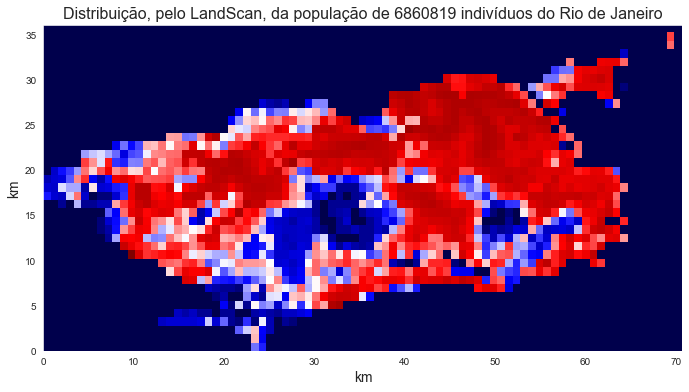

In [7]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap='seismic', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Distribuição, pelo LandScan, da população de {int(landscan_rio.sum())} indivíduos do Rio de Janeiro', fontsize=16)
plt.show()

### Sobre a resolução da malha

- Observe que a malha está visivelmente grosseira.

- Se usarmos essa resolução para posicionar os indivíduos, corremos o risco de distribuir os indivíduos em locais inabitáveis, como o mar e a baía.

- Além disso, com essa resolução, a associação com os bairros gera inconsistências.

- Para resolver isso, fazemos o seguinte:
    
    - carregamos uma matriz de bairros com uma resolução melhor; e
    
    - interpolamos os dados da matriz populacional para a resolução mais fina da matriz de bairros.
    
- Naturalmente, a interpolação deve preservar o total de habitantes de cada bloco da matriz populacional.

### Bairros

- A matriz de bairros é obtida de a partir de dados da prefeitura [link?]

- Um arquivo do tipo [shapefile](https://desktop.arcgis.com/en/arcmap/10.3/manage-data/shapefiles/what-is-a-shapefile.htm) é obtido, com a delimitação de cada bairro.

- No [QGIS](https://qgis.org/en/site/), após definirmos uma resolução espacial, exportamos os dados para uma **matriz de bairros**, associando cada bloco a um bairro.

- Aqui, definimos uma resolução 100 vezes maior do que a obtida do [LandScan](https://landscan.ornl.gov). Mais precisamente, 10 vezes mais fina em cada direção.

- Obtemos, assim, uma matriz 390 x 830.

- Cada bloco da matriz de bairros cobre uma área de 3" x 3", ou seja, aproximadamente 85,2 x 92,6 metros quadrados.

- Cada elemento da matriz é um número inteiro; cada número inteiro representando um bairro.

- São 163 bairros.

### Subblocos com os bairros

In [8]:
geoloc_Bairros_MRJ_fino = np.load(
        os.path.join('..', 'input', 'dados_rio','geoloc_Bairros_MRJ_fino.npy')
    ).astype(int)

In [9]:
print(f'Dimensão da matriz de blocos: {geoloc_Bairros_MRJ_fino.shape}')
print(f'Número de bairros: {geoloc_Bairros_MRJ_fino.max()}')

Dimensão da matriz de blocos: (390, 830)
Número de bairros: 163


### Lista de bairros

In [10]:
with open(os.path.join('..', 'input', 'dados_rio','bairros.yml')) as f:
    bairros = yaml.load(f, Loader=yaml.FullLoader)
    id_bairros = bairros['id_bairros']
    bairros_id = bairros['bairros_id']
    del(bairros)

print('Índice do bairro do FLAMENGO:', bairros_id['Flamengo'.upper()])
print('Bairro de índice 33:', id_bairros[33])

Índice do bairro do FLAMENGO: 15
Bairro de índice 33: TIJUCA


### Visualizando a divisão administrativa do Rio de Janeiro

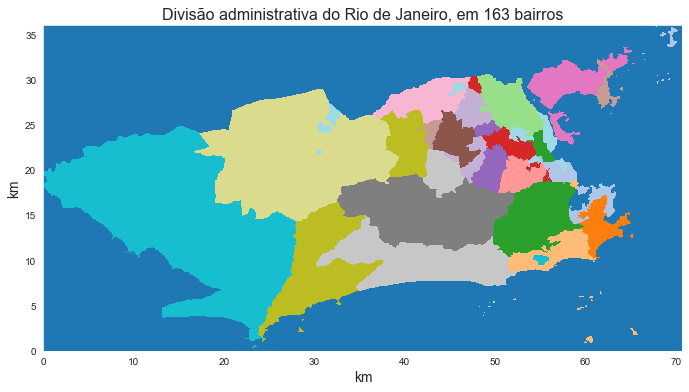

In [11]:
plt.figure(figsize=(12,6))
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro, em {geoloc_Bairros_MRJ_fino.max()} bairros',
          fontsize=16)
plt.show()

## Superposição dos bairros com o LandScan

### Diferença entre os dados de bairro e os do LandScan

Observe, na imagem abaixo, um aparente deslocamento entre as duas imagens, indicando a possibilidade de haver, ao sul da cidade, blocos do LandScan que não tenham associação com bairros.

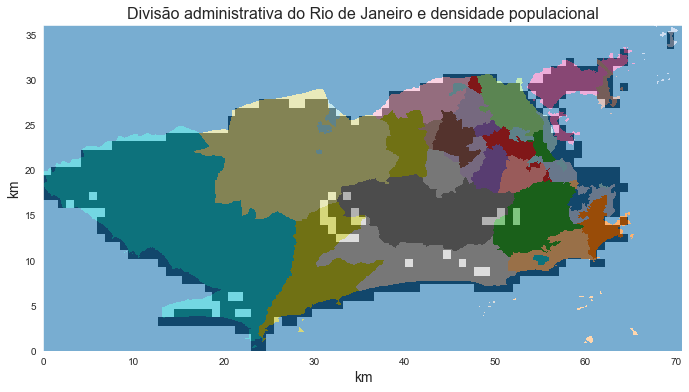

In [120]:
landscan_rio_contraste = np.minimum(landscan_rio, 1)
plt.figure(figsize=(12,6))
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.imshow(landscan_rio_contraste, cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.4)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional',
          fontsize=16)
plt.show()

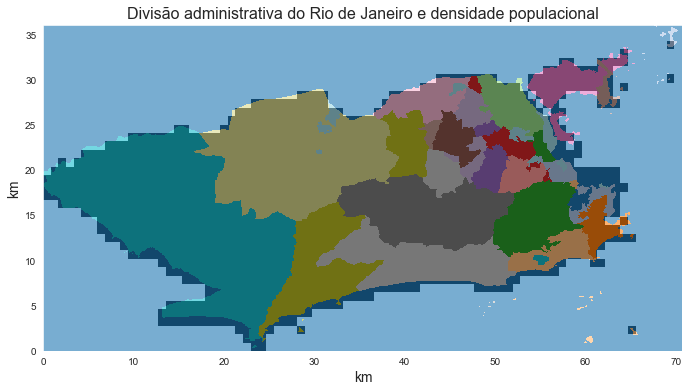

In [125]:
landscan_rio_contraste = np.minimum(landscan_rio, 1)
plt.figure(figsize=(12,6))
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.imshow(np.minimum(geoloc_bairros_MRJ,1), cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.4)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional',
          fontsize=16)
plt.show()

### Calculando a diferença

Para verificar isso, carregamos uma matriz de bairros com a mesma resolução que o Landscan e comparamos as duas matrizes.

In [151]:
geoloc_bairros_MRJ = np.load(
        os.path.join('..', 'input', 'dados_rio','novos_bairros.npy')
    ).astype(int)

In [146]:
geoloc_bairros_MRJ_contraste = np.minimum(geoloc_bairros_MRJ, 1)
contraste = geoloc_bairros_MRJ_contraste - landscan_rio_contraste
print('Blocos de bairro sem população do LandScan:', np.maximum(contraste, 0).sum())
print('Blocos do LandScan sem bairro associado:', np.maximum(-contraste, 0).sum())

Blocos de bairro sem população do LandScan: 80
Blocos do LandScan sem bairro associado: 1


In [147]:
n = np.argmin(contraste)
print(n // 83, n % 83)
print(contraste[1,81])
print(landscan_rio[1,81])
print(geoloc_bairros_MRJ[1,81])
print(landscan_rio[0:5,80:])
print(geoloc_bairros_MRJ[0:5,80:])

1 81
-1
1798
0
[[   0    0    0]
 [   0 1798    0]
 [   0 1168    0]
 [   0    0    0]
 [   0    0    0]]
[[ 0  0  0]
 [ 0  0  0]
 [ 0 13  0]
 [ 0  0  0]
 [ 0  0  0]]


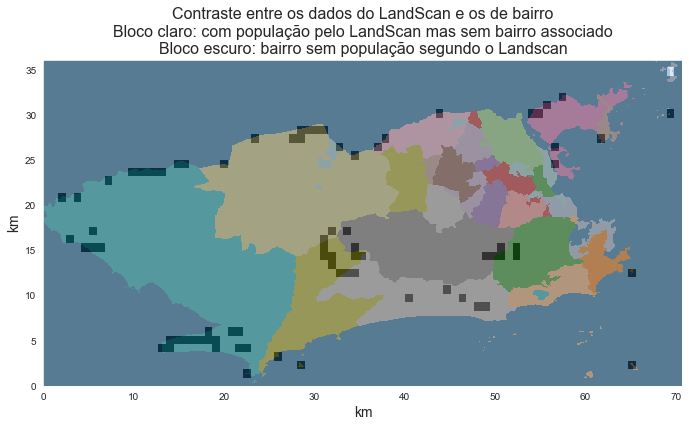

In [153]:
plt.figure(figsize=(12,6))
plt.imshow(contraste, cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.4)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Contraste entre os dados do LandScan e os de bairro\n' 
          + 'Bloco claro: com população pelo LandScan mas sem bairro associado\n'
          + 'Bloco escuro: bairro sem população segundo o Landscan',
          fontsize=16)
plt.show()

### Deslocando a matriz de bairros

- Para corrigir essa visível diferença, fazemos um deslocamento norte-sul da matriz de bairros.

- Como o deslocamento que funciona melhor é de uma fração de bloco, fazemos esse deslocamento na matriz fina de bairros.

### Implementando o deslocamento

In [215]:
deslocamento = 5
if deslocamento == 0:
    geoloc_Bairros_MRJ_fino_desloc = geoloc_Bairros_MRJ_fino
else:        
    geoloc_Bairros_MRJ_fino_desloc = np.vstack(
        [np.zeros([deslocamento, geoloc_Bairros_MRJ_fino.shape[1]]),
         geoloc_Bairros_MRJ_fino[:-deslocamento, :]
        ]
    ).astype(int)

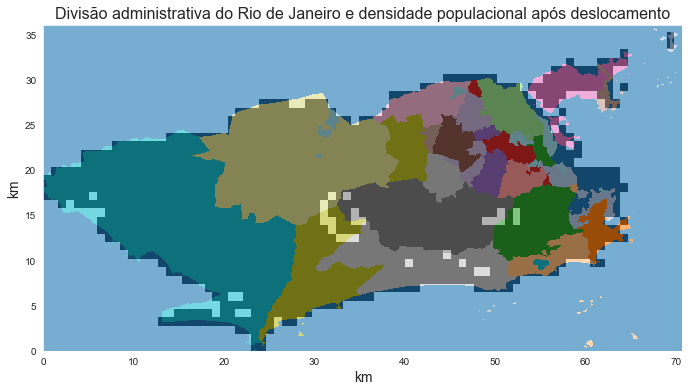

In [216]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio_contraste, cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0, landscan_rio_yextent])
plt.imshow(geoloc_Bairros_MRJ_fino_desloc, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.6)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional após deslocamento',
          fontsize=16)
plt.show()

### Criando uma matriz grossa deslocada indicando presença de bairros

In [217]:
filtro_bairros = np.zeros_like(landscan_rio)

matriz = landscan_rio
filtro = geoloc_Bairros_MRJ_fino_desloc

matriz_pop_sem_bairro = np.zeros_like(landscan_rio)

tx_refinamento_x = filtro.shape[1] // matriz.shape[1]
tx_refinamento_y = filtro.shape[0] // matriz.shape[0]

xs = list(range(matriz.shape[1]))
ys = list(range(matriz.shape[0]))

for j in xs:
    for i in ys:
        filtro_loc = filtro[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                            j*tx_refinamento_x:(j+1)*tx_refinamento_x]
        if filtro_loc.sum() > 0:
            filtro_bairros[i,j] = 1
            if matriz[i,j] == 0 and False:
                print('bairros sem população', i, j)
                print([filtro_loc.flatten()])
                print([id_bairros[k] for k in filtro_loc.flatten() if k != 0])
        elif matriz[i,j]:
            matriz_pop_sem_bairro[i,j] = matriz[i,j]
            print(f'bloco com população de {matriz[i,j]} habitantes mas sem bairro', i, j)

bloco com população de 1 habitantes mas sem bairro 7 75


In [244]:
matriz[3:8,72:78]

array([[    0,     0,     0,     5,     0,     0],
       [ 4916,  5299,  5634,  1204,     0,     0],
       [ 7172,  7895,     0,     0,     0,     0],
       [11993,  7993,     0,     0,     0,     0],
       [ 7290,  6494,     0,     1,     0,     0]])

- Minha sugestão é pegar esses habitantes em blocos sem bairro, juntar todos eles, zerar os coeficientes correspondentes da matriz populacional e realocá-los, aleatoriamente, para outros blocos já povoados. Serão poucos, independentemente do deslocamento.

- Na verdade, usando o deslocamento = 5, temos apenas 1 habitante sem bairro, que podemos colocar diretamente em outro bloco próximo. O único problema disso é que não é flexível, caso queiramos mexer no deslocamento.

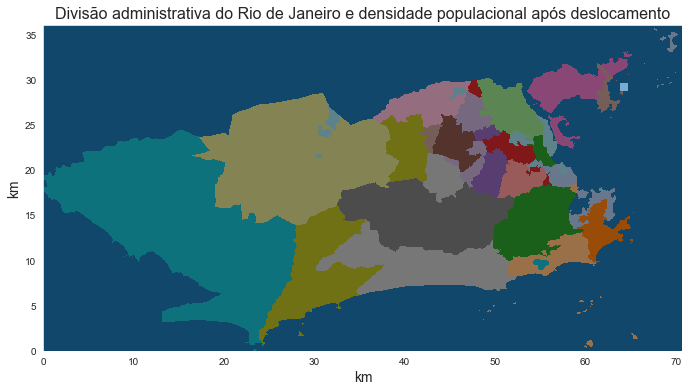

In [218]:
plt.figure(figsize=(12,6))
#plt.imshow(landscan_rio_contraste, cmap='Blues', interpolation='none',
#           extent=[0,landscan_rio_xextent,0, landscan_rio_yextent])
#plt.imshow(filtro_bairros, cmap='Reds', interpolation='none', alpha=0.5,
#           extent=[0,landscan_rio_xextent,0, landscan_rio_yextent])
plt.imshow(filtro, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=1)
plt.imshow(np.minimum(matriz_pop_sem_bairro,1), cmap='gray', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.4)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Divisão administrativa do Rio de Janeiro e densidade populacional após deslocamento',
          fontsize=16)
plt.show()

In [219]:
contraste = filtro_bairros - landscan_rio_contraste
print('Blocos de bairro sem população do LandScan:', np.maximum(contraste, 0).sum())
print('Blocos com populacao pelo landscan mas sem bairro associado:', np.maximum(-contraste, 0).sum())

Blocos de bairro sem população do LandScan: 198
Blocos com populacao pelo landscan mas sem bairro associado: 1


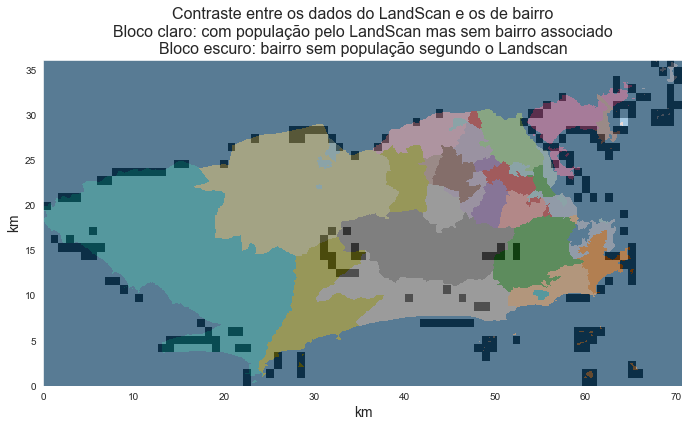

In [220]:
plt.figure(figsize=(12,6))
plt.imshow(contraste, cmap='binary', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.imshow(geoloc_Bairros_MRJ_fino, cmap='tab20', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent], alpha=0.4)
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Contraste entre os dados do LandScan e os de bairro\n' 
          + 'Bloco claro: com população pelo LandScan mas sem bairro associado\n'
          + 'Bloco escuro: bairro sem população segundo o Landscan',
          fontsize=16)
plt.show()

## Refinamento da malha populacional

- Vamos interpolar os dados, mas devemos tomar cuidado em preservar o total da população de cada bloco.

- Uma solução para essa interpolação é a seguinte:

    - interpretar o número de habitantes por bloco como uma distribuição de probabilidade;
    
    - interpolar essa distribuição de maneira linear por partes;
    
    - distribuir as residências e os habitantes de cada bloco pelos subblocos, usando a distribuição interpolada como pesos.
   
- Caso haja uma sobra, por conta da possibilidade de nem todos os blocos do LandScan estarem associados a um bairro, essa sobra também é distribuída aleatoriamente, desta vez em toda a região, usando também a distribuição interpolada como pesos.

In [221]:
filtro_bairros = np.zeros_like(landscan_rio)

matriz = landscan_rio
filtro = geoloc_Bairros_MRJ_fino_desloc

tx_refinamento_x = filtro.shape[1] // matriz.shape[1]
tx_refinamento_y = filtro.shape[0] // matriz.shape[0]

xs = list(range(matriz.shape[1]))
ys = list(range(matriz.shape[0]))

for j in xs:
    for i in ys:
        filtro_loc = filtro[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                            j*tx_refinamento_x:(j+1)*tx_refinamento_x]
        if filtro_loc.sum() > 0:
            filtro_bairros[i,j] = 1

In [222]:
def refina_matriz(matriz, filtro):
    '''
    Gera uma matriz "refinada" via interpolação linear e uma matriz fina como filtro.  
    '''
    matriz_fina = np.zeros_like(filtro)
    id_nao_alocados = list() 
    
    tx_refinamento_x = filtro.shape[1] // matriz.shape[1]
    tx_refinamento_y = filtro.shape[0] // matriz.shape[0]

    xs = list(range(matriz.shape[1]))
    ys = list(range(matriz.shape[0]))

    xs_fino = np.arange(0, matriz.shape[1], 1/tx_refinamento_x)
    ys_fino = np.arange(0, matriz.shape[0], 1/tx_refinamento_y)

    f = interp2d(xs, ys, matriz, kind='linear')
    matriz_interp = f(xs_fino, ys_fino)*np.minimum(filtro,1)

    for j in xs:
        for i in ys:
            if matriz[i,j]:
                matriz_interp_local \
                    = matriz_interp[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                    j*tx_refinamento_x:(j+1)*tx_refinamento_x]
                if matriz_interp_local.sum() > 0:
                    distrib = np.floor(matriz[i,j]*matriz_interp_local
                                           / matriz_interp_local.sum()
                                      ).astype('int')
                    sobra = matriz[i,j] - distrib.sum()
                    sobra_posicionamento \
                        = np.random.choice(tx_refinamento_x*tx_refinamento_y,
                                           sobra,
                                           replace=True,
                                           p=(matriz_interp_local
                                              /matriz_interp_local.sum()
                                             ).flatten()
                                          )
                    for loc in sobra_posicionamento:
                        distrib[loc // tx_refinamento_x,
                                loc % tx_refinamento_x] += 1
                    matriz_fina[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                j*tx_refinamento_x:(j+1)*tx_refinamento_x] \
                        = distrib
                else:
                    id_nao_alocados.append([i,j])
                        
    total_nao_alocados = sum([matriz[ij[0], ij[1]] for ij in id_nao_alocados])
    print(total_nao_alocados)
    print(id_nao_alocados)
    distrib_nao_alocados \
        = np.random.choice(filtro.shape[0]*filtro.shape[1],
                           total_nao_alocados,
                           replace=False,
                           p=(matriz_interp/matriz_interp.sum()).flatten()
                          )
        
    for na in distrib_nao_alocados:
        matriz_fina[na // filtro.shape[1], na % filtro.shape[1]] += 1
    
    return matriz_fina

In [223]:
landscan_rio_fino = refina_matriz(landscan_rio, geoloc_Bairros_MRJ_fino_desloc)

1
[[7, 75]]


In [224]:
print('População total na matriz populacional:', landscan_rio.sum())
print('População total na matriz refinada:', landscan_rio_fino.sum())
print('Não alocados:', landscan_rio.sum() - landscan_rio_fino.sum())

População total na matriz populacional: 6860819
População total na matriz refinada: 6860819
Não alocados: 0


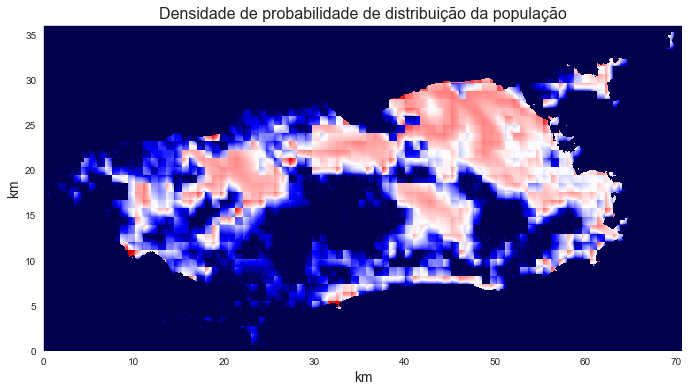

In [225]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio_fino), cmap='seismic', interpolation='none',
           extent=[0,landscan_rio_xextent,0,landscan_rio_yextent])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Densidade de probabilidade de distribuição da população', fontsize=16)
plt.show()

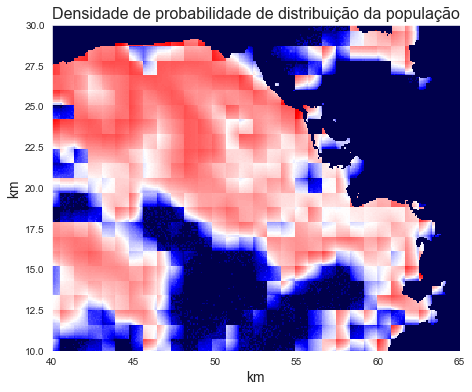

In [226]:
plt.figure(figsize=(12,6))
fino_ydim, fino_xdim = landscan_rio_fino.shape
plt.imshow(np.log(1 + landscan_rio_fino[1 * fino_ydim // 7:5 * fino_ydim // 7,
                                        8 * fino_xdim // 14: 13 * fino_xdim // 14]),
           cmap='seismic', interpolation='none',
           extent=[8 *landscan_rio_xextent // 14, 13 *landscan_rio_xextent // 14,
                   2 * landscan_rio_yextent // 7, 6 * landscan_rio_yextent // 7])
plt.grid(False)
plt.xlabel('km', fontsize=14)
plt.ylabel('km', fontsize=14)
plt.title(f'Densidade de probabilidade de distribuição da população', fontsize=16)
plt.show()

## Distribuição das pessoas e das residências pelos blocos do reticulado

- A distribuição das pessoas não segue apenas o número de habitantes por bloco.

- A residência à qual pertencem é importante.

- E o número de indivíduos em cada residência, também.

- O número de indivíduos por residência não é totalmente aleatório, segue uma certa distribuição.

- Buscamos combinar as informações de número de habitantes por bloco com essa distribuição.


## Blocos versus subblocos

- Nos códigos abaixo, temos a opção de distribuir as residências e os indivíduos de três formas:

    - De uma vez só, em toda a região;
    
    - Em cada bloco da matriz populacional `landscan_rio`;
    
    - Em cada subbloco da matriz populacional fina `landscan_rio_fino`.
    
- Nos dois primeiros casos, temos que, em um passo seguinte, distribuir as residências geradas (e, junto com isso, os seus residentes) em cada subbloco da matriz fina.

- No terceiro caso, essa etapa é desnecessária.

- Porém, ao utilizamos o terceiro caso, por conta da população em alguns subblocos ser pequena, a densidade de distribuição de residências por tamanho da residência foge um pouco da densidade desejada. Isso é mais significativo ao trabalharmos com uma população reduzida.

- Por outro lado, ao utilizarmos o primeiro caso, mesmo com uma população bem reduzida, a densidade de distribuição de residências por tamanho da residência é mais bem alcançada. Por outro lado, ao fazermos, posteriormente, a alocação nos subblocos, essa densidade, por subbloco, pode ficar comprometida.

- Por esses motivos, a segunda opção é a utilizada aqui.

- Vale ressaltar que apenas o número de habitantes por bloco é seguido à risca.

- O número de habitantes por subbloco, obtido com a interpolação, é utilizado como distribuição de probabilidade, no momento de distribuir as residências.

### Densidade populacional por tamanho de residência

- Não temos dados reais completos de densidade populacional por tamanho de residência para o município do Rio de Janeiro.

- Utilizamos, então, uma distribuição sintética baseada em informações parciais.

- Um ponto de partida são os dados dos EUA, disponíveis no suplemento do artigo de 2006.

- Em relação a esses dados, pensando na realidade do Rio de Janeiro:

    - reduzimos as densidades das residências com poucos indivíduos

    - aumentamos as das residências com muitos moradores.

- Temos, ainda, esses dados parciais do censo de **2010** para a *cidade do Rio de Janeiro*:

    - Número de habitantes em 2010: 6.320.446
    
    - Número de residências ocupadas (domicílios) em 2010: 2.147.264
    
    - Média: 2.9435
    
    - Fonte: [IBGE Censo 2010 Rio de Janeiro/RJ](https://cidades.ibge.gov.br/brasil/rj/rio-de-janeiro/pesquisa/23/27652)

- Assim, chegamos na distribuição exibida abaixo. 

In [227]:
dens_tam_res = [.21, .26, .20, .17, .08, .04, .02, 0.02]
media_tam_res = sum([dens_tam_res[j]*(j+1)
             for j in range(len(dens_tam_res))])
print(f'Casas de 1 a {len(dens_tam_res)} moradores')
print(f'Com respectivas densidades de probabilidade:\n  {dens_tam_res}')
print(f'Total: {sum(dens_tam_res)}')
print(f'Média de moradores por residência: {media_tam_res:.2f}')

Casas de 1 a 8 moradores
Com respectivas densidades de probabilidade:
  [0.21, 0.26, 0.2, 0.17, 0.08, 0.04, 0.02, 0.02]
Total: 1.0
Média de moradores por residência: 2.95


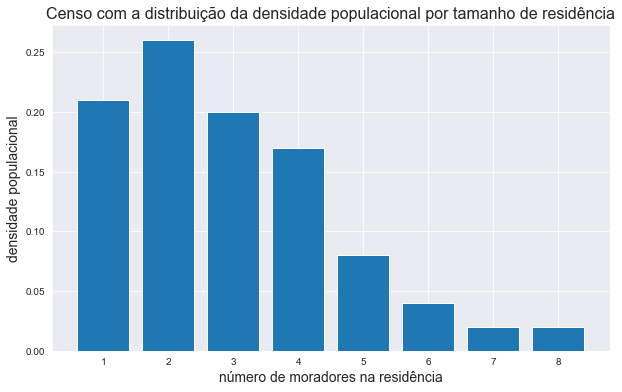

In [228]:
plt.figure(figsize=(10,6))
plt.bar(range(1,len(dens_tam_res)+1), dens_tam_res)
plt.xlabel('número de moradores na residência', fontsize=14)
plt.ylabel('densidade populacional', fontsize=14)
plt.title('Censo com a distribuição da densidade populacional por tamanho de residência',
          fontsize=16)
plt.show()

In [229]:
def gera_tam_residencias(num_pop, dens_tam_res):
    '''
    Retorna uma "lista de residências", indicando o tamanho de cada uma delas.
    
    A densidade de residências por tamanho de residência `dens_tam_res` 
    é utilizada como densidade de probabilidade para a geração das residências 
    por tamanho.
    '''
    len_tam_res = len(dens_tam_res)
    tam_res = range(1, len_tam_res + 1)
    
    res_tam = list() # tamanho de cada residência
    sobra = num_pop
    while sobra > 0:
        k = sobra // len_tam_res + 1
        res_tam += random.choices(tam_res, weights=dens_tam_res, k=k)
        sobra = num_pop - sum(res_tam)
    
    res_tam[-1] = num_pop - sum(res_tam[:-1])
    return res_tam

In [230]:
def associa_pop_residencia(res_tam, res_0=0, ind_0=0):
    '''
    Retorna uma lista com a residência de cada indivíduo
    e uma lista com os indivíduos em cada residência.
    
    Isso é feito a partir da lista do tamanho de cada residência.
    
    A população é associada, por ordem de índice, a cada residência.
    '''
    num_pop = sum(res_tam)
    pop_res = list() # índice da residência de cada indivíduo
    res_pop = list() # índice dos indivíduos em cada residência
    individuo = ind_0
    residencia = res_0
    for j in range(len(res_tam)):
        pop_res += res_tam[j]*[residencia + j]
        res_pop.append(list(range(individuo, individuo + res_tam[j])))
        individuo += res_tam[j]
    return pop_res, res_pop

In [231]:
def distribui_pop_e_res(matriz_pop, dens_tam_res):
    '''
    Distribui as residências e seus residentes pelo reticulado.
    
    Cada coeficiente da matriz populacional `matriz_pop` indica o
    número de indivíduos no bloco correspondente do reticulado associado
    à matriz.
    
    A distribuição das residências e dos seus residentes é feita bloco
    a bloco, através da função `associa_pop_residencia()`.    
    '''

    ydim, xdim = matriz_pop.shape
    
    # lista indexada pela residência, indicando o seu tamanho
    res_tam = list()
    
    # lista indexada pela residência, indicando a lista de seus residentes
    res_pop = list() 

    # lista indexada pelos indivíduos, indicando o índice da sua residência
    pop_res = list() 

    # lista indexada pelo bloco flattened da matriz_pop, indicando o índice
    # do sua primeira residência
    bl_res = [0]    
    # lista indexada pelo bloco flattened da matriz_pop, indicando o índice
    # do seu primeiro residente
    bl_pop = [0]


    res_cum = 0
    ind_cum = 0

    for j in range(xdim * ydim):
        num_pop_local = matriz_pop[j // xdim, j % xdim]
        if num_pop_local > 0:
            res_tam_local = gera_tam_residencias(num_pop_local,
                                                 dens_tam_res)
            pop_res_local, res_pop_local \
                = associa_pop_residencia(res_tam_local,
                                         res_cum,
                                         ind_cum)
            res_tam += res_tam_local
            pop_res += pop_res_local
            res_pop += res_pop_local
            res_cum += len(res_tam_local)
            ind_cum += num_pop_local
        bl_res.append(res_cum)
        bl_pop.append(ind_cum)
    
    return res_tam, res_pop, pop_res, bl_pop, bl_res

In [232]:
tx_reducao = 1

In [233]:
%%time
res_tam, res_pop, pop_res, bl_pop, bl_res \
    = distribui_pop_e_res(landscan_rio//tx_reducao, dens_tam_res)

CPU times: user 9.79 s, sys: 403 ms, total: 10.2 s
Wall time: 12.1 s


In [234]:
%%time
res_tam_fino, res_pop_fino, pop_res_fino, bl_pop_fino, bl_res_fino \
    = distribui_pop_e_res(landscan_rio_fino//tx_reducao, dens_tam_res)

CPU times: user 14.9 s, sys: 637 ms, total: 15.5 s
Wall time: 24.8 s


In [235]:
len_tam_res = len(dens_tam_res)

densidade = len_tam_res * [0]
for r in res_tam:
    densidade[r-1] += 1
    
densidade = [d/sum(densidade) for d in densidade]
    
densidade_fino = len_tam_res * [0]
for r in res_tam_fino:
    densidade_fino[r-1] += 1
    
densidade_fino = [d/sum(densidade_fino) for d in densidade_fino]

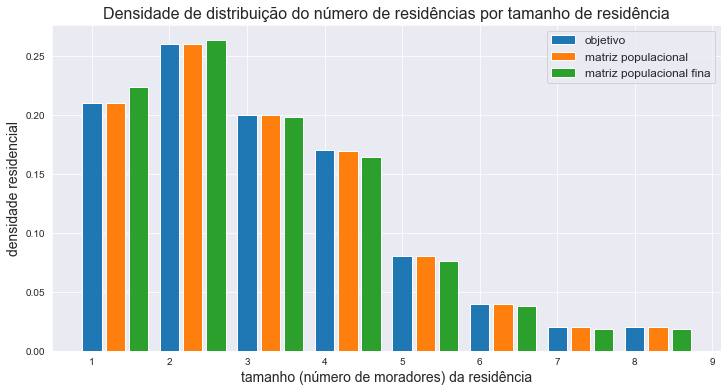

In [236]:
bar_width = 0.25
r1 = [j for j in range(1,len_tam_res+1)]
r2 = [j+0.3 for j in range(1,len_tam_res+1)]
r3 = [j+0.6 for j in range(1,len_tam_res+1)]

plt.figure(figsize=(12,6))
plt.bar(r1, dens_tam_res, width=bar_width, label='objetivo')
plt.bar(r2, densidade, width=bar_width,
        label=f'matriz populacional')
plt.bar(r3, densidade_fino, width=bar_width,
        label=f'matriz populacional fina')
plt.xlabel('tamanho (número de moradores) da residência', fontsize=14)
plt.ylabel('densidade residencial', fontsize=14)
plt.legend(fontsize=12)
plt.title(f'Densidade de distribuição do número de residências por tamanho de residência',
          fontsize=16)
plt.show()    

### Alocação nos subblocos

- Com as residências e os indivíduos alocados nos blocos da matriz populacional, vamos alocá-los nos subblocos.

- Dessa forma, evitamos que residências fiquem em área inabitáveis, como o mar, por exemplo.


In [237]:
j = 10

num_res_bloco = bl_res[j+1] - bl_res[j]

res = list(range(bl_res[j], bl_res[j+1]))
print(bl_res[j])
print(bl_res[j+1])
print(res)
print(num_res_bloco)
print(len(res))

pesos = landscan_rio_fino.flatten()
xdim_fino = landscan_rio_fino.shape[1]
#random.choices(100, weights=pesos, k=k)
print(len(pesos[pesos>0]))
print(len(pesos[pesos==0]))
print(landscan_rio_fino.shape)
print(390*830)
print(xdim_fino)
pesos[j*x]

0
0
[]
0
0
107479
216221
(390, 830)
323700
830


NameError: name 'x' is not defined

In [ ]:
matriz = landscan_rio
matriz_fina = landscan_rio_fino

ydim, xdim = matriz.shape
ydim_fina, xdim_fina = matriz_fina.shape

tx_refinamento_x = matriz_fina.shape[1] // matriz.shape[1]
tx_refinamento_y = matriz_fina.shape[0] // matriz.shape[0]

xs = list(range(matriz.shape[1]))
ys = list(range(matriz.shape[0]))

bl_sub = list()

count = 0
for j in xs:
    for i in ys:
        l = i*xdim + j
        num_res_local = bl_res[l+1] - bl_res[l]
        if num_res_local > 0:
            matriz_fina_local \
                = matriz_fina[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                              j*tx_refinamento_x:(j+1)*tx_refinamento_x]
            count +=1
            if matriz_fina_local.sum() == 0:
                print(i,j,l,num_res_local)
            else:
                locais \
                    = np.random.choice(tx_refinamento_x*tx_refinamento_y,
                                       num_res_local,
                                       replace=True,
                                       p=(matriz_fina_local/matriz_fina_local.sum()
                                         ).flatten()
                                      )
                

print(count)

In [ ]:
xs[-1]
print(matriz.shape)
print(xs[-1])
print(ys[-1])
print(38*xdim+82)
print(ys[-1]*xdim+xs[-1], bl_res[ys[-1]*xdim+xs[-1]])
print(ys[-1]*xdim+xs[-1]+1, bl_res[ys[-1]*xdim+xs[-1]+1])
print(len(bl_res))

In [ ]:
        
        
        if matriz[i,j]:
            matriz_interp_local \
                = matriz_interp[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                j*tx_refinamento_x:(j+1)*tx_refinamento_x]
            if matriz_interp_local.sum() > 0:
                distrib = np.floor(matriz[i,j]*matriz_interp_local
                                       / matriz_interp_local.sum()
                                  ).astype('int')
                sobra = matriz[i,j] - distrib.sum()
                sobra_posicionamento \
                    = np.random.choice(tx_refinamento_x*tx_refinamento_y,
                                       sobra,
                                       replace=False,
                                       p=(matriz_interp_local
                                          /matriz_interp_local.sum()
                                         ).flatten()
                                      )

In [ ]:
def aloca_res(matriz_pop, matriz_fina, res_tam, bl_res):
    '''
    Distribui as residências e seus residentes pelo reticulado fino.
    
    Cada coeficiente da matriz populacional `matriz_pop` indica o
    número de indivíduos no bloco correspondente do reticulado associado
    à matriz.
    
    A distribuição das residências e dos seus residências é feita bloco
    a bloco, através da função `associa_pop_residencia()`.    
    '''

    ydim, xdim = matriz_pop.shape
    
    res_tam = list()
    res_pop = list()
    pop_res = list()

    bl_pop = [0]
    bl_res = [0]

    res_cum = 0
    ind_cum = 0

    for j in range(xdim * ydim):
        num_pop_local = matriz_pop[j // xdim, j % xdim]
        if num_pop_local > 0:
            res_tam_local = gera_tam_residencias(num_pop_local,
                                                 dens_tam_res)
            pop_res_local, res_pop_local \
                = associa_pop_residencia(res_tam_local,
                                         res_cum,
                                         ind_cum)
            res_tam += res_tam_local
            pop_res += pop_res_local
            res_pop += res_pop_local
            res_cum += len(res_tam_local)
            ind_cum += num_pop_local
            bl_res.append(res_cum)
            bl_pop.append(ind_cum)
    
    return res_tam, res_pop, pop_res, bl_pop, bl_res

## Posicionamento das residências e dos indivíduos

- Com as residências e os indivíduos alocados nos subblocos da matriz populacional fina, vamos posicioná-los dentro dos subblocos, dando a eles coordenadas de longitude e latitude.

- Faremos isso com coordenadas relativas, com a origem em ???

- 

## Referências

- 

<!--NAVIGATOR-->

---
[<- Descrição dos atributos dos indivíduos e das residências](A1.01-Atributos_dos_individuos.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Descrição dos atributos de idade e infectividade potencial relativa dos indivíduos ->](A1.03-Atributos_de_idade_e_infectividade.ipynb)